# Análise de Elasticidade

In [3]:
# Importando as bibliotecas

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [4]:
# lendo o arquivo CSV

data = pd.read_csv("dados_diarios.csv", header=(0))

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     175 non-null    object
 1   Custo    175 non-null    object
 2   Receita  175 non-null    object
dtypes: object(3)
memory usage: 4.2+ KB


In [6]:
# Usando o "drop" para tirar a coluna data

data = data.drop(columns=["Data"])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Custo    175 non-null    object
 1   Receita  175 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


In [8]:
# Tratamento dos dados, tirando os pontos, e trocando a virgula por ponto, deixando assim no padrão americano.

data = pd.concat(
    [
        data[col]
        .str.split()
        .str[0]
        .str.replace(".", "", regex=False)
        .str.replace(
            ",",
            ".",
        )
        .str.strip()
        for col in data
    ],
    axis=1,
)

In [9]:
# Definindo a melhor função para criação do modelo não linear. Neste caso a melhor função é a logistica, pois com ela molda 
# uma sigmoíde, onde podemos observar o ponto de inflexão, além dos pontos de máximo margina e máximo médio.

def funcao(x, a, b, c):
    return a / (1 + (np.exp((b - x) / c)))

In [10]:
# definindo as colunas do dataframe, tirando dados duplicados e transformando os dados, ou seja passando de string para float

x = data["Custo"].unique().astype("float")
y = data["Receita"].unique().astype("float")


In [11]:
# Normalizou para o intervalo entre 0 e 1, pois o curvefit não modela para números muito grande

xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
x_new = (x - xmin) / (xmax - xmin)
y_new = (y - ymin) / (ymax - ymin)

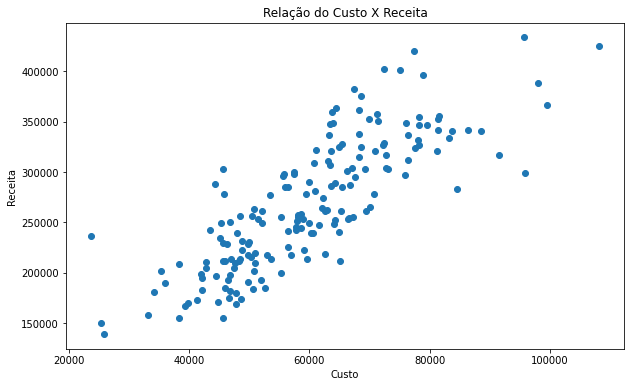

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, "o")
plt.title("Relação do Custo X Receita")
plt.xlabel("Custo")
plt.ylabel("Receita")
plt.show()

In [13]:
# Criando o modelo a partir da função logística e com os novos valores de x normalizados

p, pcov = curve_fit(funcao, x_new, y_new)

In [14]:
# Criando o CUSTO do modelo em um espaço linear com a função lindspace, que é a criação de um espaço linear que vai de 
# 0 até 175, igualmente espaçados de 1 em 1.

xarray = np.linspace(0, 1, 175)

In [15]:
# Estimando a RECEITA do modelo, através do array do numpy.

yarray = np.array([funcao(x, *p) for x in xarray])

In [16]:
# Voltando para o intervalo original

xarray_new = (xarray * (xmax - xmin)) + xmin
yarray_new = (yarray * (ymax - ymin)) + ymin

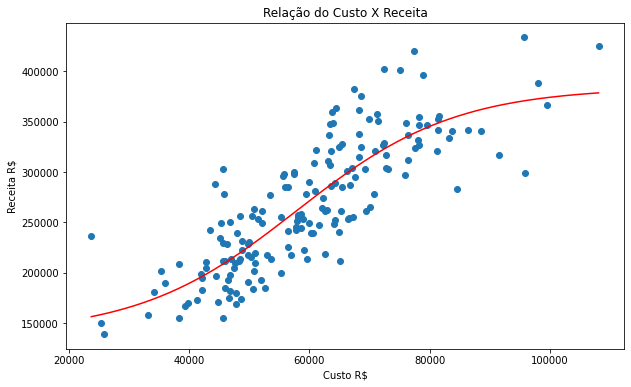

In [17]:
# Plotando o gráfico predito
plt.figure(figsize=(10, 6))
plt.plot(x, y, "o")
plt.title("Relação do Custo X Receita")
plt.xlabel("Custo R$")
plt.ylabel("Receita R$")
plt.plot(xarray_new, yarray_new, "red")
plt.show()

In [18]:
r_score = r2_score(sorted(y), sorted(yarray_new))
print(r_score)

0.7891866235794608


In [19]:
print(spearmanr(y, x))

SpearmanrResult(correlation=0.8384012539184952, pvalue=1.8271207542182425e-47)


In [20]:
# Ordena os índices

idx = np.argsort(xarray_new)
x_sorted = xarray_new[idx]
y_sorted = yarray_new[idx]

In [21]:
# Calcula a derivada, para encontrar o produto marginal

derivadas = [0]
for i in range(1, len(yarray_new)):
    derivadas.append((y_sorted[i] - y_sorted[i - 1]) / (x_sorted[i] - x_sorted[i - 1]))
derivadas = np.array(derivadas)

* Produto Médio: É a divisão da receita pelo custo do modelo. É o gráfico verde abaixo.

* Um exemplo seria que cinco pessoas podem operar uma linha de montagem melhor do que duas, porém dez pessoas podem trope e cair umas nas outras, diminuindo a produtividade.

* Produto marginal: delta q/delta L, é a variação da receita predita / variação do custo (derivada).

* Agora relacionando os dois gráficos, podemos identificar alguns pontos, existe o gráfico azul Ou seja, em dado momento ocorre o máximo de esforço para obter receita, depois começa a cair, chegando num ponto em que o investimento não é mais o "ótimo", não é o mais esperado. Esse ponto é onde oa

In [22]:
max_derivadas = xarray_new[np.argmax(derivadas)] # Para saber o índice da posição onde a máxima derivada tem seu vértice 
# e com isso saber o valor do máximo marginal

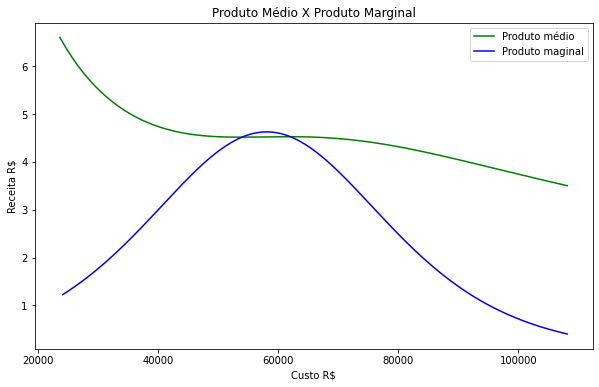

In [37]:
plt.figure(figsize=(10, 6))
plt.title("Produto Médio X Produto Marginal")
plt.xlabel("Custo R$")
plt.ylabel("Receita R$")
plt.plot(xarray_new, yarray_new / xarray_new, "green", label="Produto médio") 
plt.plot(xarray_new[1:], derivadas[1:], "blue", label="Produto maginal")
plt.legend()
plt.show()

* Queremos achar o ponto máximo do gráfico azul e também queremos achar a interseção entre ambos, por isso fazemos um gráfico menos o outro, ou seja, o produto médio menos o produto margina, e como queremos apenas a interseção depois do ponto máximo, pegamos o segundo valor. 
* O np.absolute pega o módulo dos valores
* argsort retorna os indices que estão os pontos de interseção

In [24]:
menor = np.argsort(np.absolute((yarray_new / xarray_new) - derivadas))
indice_intersecao_direita = menor[0] if xarray_new[menor[0]] > xarray_new[menor[1]] else menor[1]

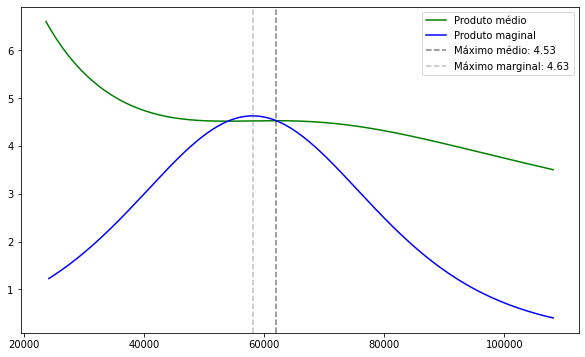

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(xarray_new, yarray_new / xarray_new, "green", label="Produto médio") 
plt.plot(xarray_new[1:], derivadas[1:], "blue", label="Produto maginal")

plt.axvline( # Adiciona uma linha vertical na posição x
    x=xarray_new[indice_intersecao_direita],
    color="black",
    label=f"Máximo médio: {round(yarray_new[indice_intersecao_direita] / xarray_new[indice_intersecao_direita], 2)}",
    linestyle="--",
    alpha=0.5,
)

plt.axvline(
    x=max_derivadas,
    color="grey",
    label=f"Máximo marginal: {round(max(derivadas), 2)}",
    linestyle="--",
    alpha=0.5,
)
plt.legend()

In [26]:
print(f"Máximo_marginal= R$ {round(max_derivadas, 2)}, Receita= R$ {round(yarray_new[np.argmax(derivadas)], 2)}")
print(f"Máximo_Médio= R$ {round(xarray_new[indice_intersecao_direita], 2)}, Receita= R$ {round(yarray_new[indice_intersecao_direita], 2)}")

Máximo_marginal= R$ 58159.04, Receita= R$ 262992.23
Máximo_Médio= R$ 62040.82, Receita= R$ 280795.07


O resultado máximo margina e máximo médio nos diz o qual o intervalo que representa o melhor investimento. Sendo assim, o máximo de investimento seria R$ 62040,82.

Feedback:
- Desenvolvimento correto.
- É necessário plotar um gráfico com o máximo marginal e o máximo médio em cima da curva logistica para ter uma melhor visualização.

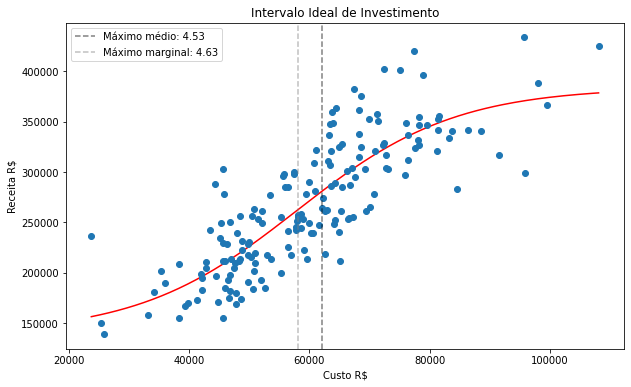

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(xarray_new, yarray_new, "red")
plt.plot(x, y, "o")
plt.xlabel("Custo R$")
plt.ylabel("Receita R$")
plt.title("Intervalo Ideal de Investimento")

plt.axvline( # Adiciona uma linha vertical na posição x
    x=xarray_new[indice_intersecao_direita],
    color="black",
    label=f"Máximo médio: {round(yarray_new[indice_intersecao_direita] / xarray_new[indice_intersecao_direita], 2)}",
    linestyle="--",
    alpha=0.5,
)

plt.axvline(
    x=max_derivadas,
    color="grey",
    label=f"Máximo marginal: {round(max(derivadas), 2)}",
    linestyle="--",
    alpha=0.5,
)
plt.legend()